# Random Forest model for mortality prediction
### We're going to do the following in this notebook : 
    1) Random Forest
    2) Random forest model with only selecting important features

### Importing necessary libraries

In [45]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import os
sns.set()
# Access data.
from google.colab import drive
drive.mount('/content/gdrive')
from google.colab import files

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
oversample = SMOTE()
scaler = StandardScaler()

## Load dataset

In [47]:
uploaded = files.upload()

Saving rawdata.csv to rawdata (1).csv


In [0]:
import io
icudata = pd.read_csv(io.BytesIO(uploaded['rawdata.csv']))

In [49]:
icudata

,age,height,weight,eyes,motor,verbal,GCSTotal,temperature,respiratoryrate,heartrate,glucose,O2,fio2,ph,los,SBP,DBP,MAP,ethnicity,gender,hosp_alive,icu_alive
0,81.0,165.1,61.70,4.0,6.0,5.0,15.0,34.8,5.0,114.0,185.0,95.0,60.0,7.390,10.893056,103.366634,55.650501,71.555879,1.0,1,0,0
1,59.0,180.3,92.30,4.0,6.0,5.0,15.0,37.2,10.0,114.0,121.0,98.0,21.0,6.700,10.679861,132.334862,57.155963,82.215596,1.0,0,0,0
2,80.0,170.2,103.30,4.0,6.0,5.0,15.0,36.6,55.0,102.0,273.0,97.0,21.0,6.700,3.610417,112.200000,59.900000,77.333333,1.0,0,0,0
3,63.0,183.0,118.00,4.0,6.0,5.0,15.0,37.3,26.0,100.0,143.0,97.0,60.0,7.450,2.949306,128.652968,60.463470,83.193303,1.0,0,0,0
4,60.0,165.1,79.90,4.0,6.0,4.0,14.0,34.5,37.0,137.0,273.0,99.0,40.0,7.070,3.611806,117.556477,62.197927,80.650777,1.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17888,51.0,180.3,59.00,4.0,6.0,3.0,13.0,34.5,26.0,56.0,192.0,92.0,100.0,7.444,11.053472,130.552042,67.630504,88.604350,3.0,0,0,0
17889,51.0,170.2,63.05,1.0,1.0,1.0,3.0,34.5,33.0,86.0,273.0,88.0,100.0,7.404,2.611111,115.167622,61.166189,79.166667,0.0,1,1,1
17890,66.0,157.5,71.50,4.0,6.0,3.0,13.0,35.8,50.0,115.0,209.0,81.0,100.0,7.494,29.383333,122.685241,49.463950,73.871047,1.0,1,0,0
17891,50.0,165.1,59.00,1.0,5.0,1.0,7.0,34.9,14.0,62.0,182.0,97.0,100.0,7.185,2.145833,134.452465,77.519366,96.497066,3.0,1,0,0


### Dropping any null values

In [50]:
icudata = icudata.dropna()
icudata = icudata.drop('icu_alive',axis=1)
icudata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17764 entries, 0 to 17892
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              17764 non-null  float64
 1   height           17764 non-null  float64
 2   weight           17764 non-null  float64
 3   eyes             17764 non-null  float64
 4   motor            17764 non-null  float64
 5   verbal           17764 non-null  float64
 6   GCSTotal         17764 non-null  float64
 7   temperature      17764 non-null  float64
 8   respiratoryrate  17764 non-null  float64
 9   heartrate        17764 non-null  float64
 10  glucose          17764 non-null  float64
 11  O2               17764 non-null  float64
 12  fio2             17764 non-null  float64
 13  ph               17764 non-null  float64
 14  los              17764 non-null  float64
 15  SBP              17764 non-null  float64
 16  DBP              17764 non-null  float64
 17  MAP         

## Splitting into train and test dataset

In [51]:
feature_cols = ['age','height','weight','eyes','motor','verbal','GCSTotal','temperature','respiratoryrate','heartrate','glucose','O2','fio2','ph','los','SBP','DBP','MAP','ethnicity','gender']
x = icudata.drop('hosp_alive',axis=1)
y = icudata.hosp_alive
x,y = oversample.fit_resample(x,y)
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y,    #splitting 
                                                    test_size=0.25, 
                                                    random_state=0)
#x_train, y_train = oversample.fit_resample(x_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Feature Scaling

In [0]:
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Random Forest classifier

In [53]:
rfmodel = RandomForestClassifier(n_estimators=100,class_weight='balanced')
rfmodel.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
predictions_rf = rfmodel.predict(x_test)
rf_prob = rfmodel.predict_proba(x_test)

### Keeping positive outcomes only (expired patient)

In [0]:
rf_prob = rf_prob[:,1]

## Classification Report

In [56]:
rf_acc = rfmodel.score(x_test, y_test)
print(classification_report(y_test,predictions_rf))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      3706
           1       0.94      0.89      0.91      3693

    accuracy                           0.92      7399
   macro avg       0.92      0.92      0.92      7399
weighted avg       0.92      0.92      0.92      7399



In [0]:
p = metrics.precision_score(y_test, predictions_rf)
r = metrics.recall_score(y_test, predictions_rf)
f1 = metrics.f1_score(y_test, predictions_rf)

In [0]:
rf_fpr, rf_tpr, thresholds = metrics.roc_curve(y_test, rf_prob)
rf_auc = metrics.roc_auc_score(y_test, rf_prob)

In [59]:
print('*'*30)
print(f'Random Forest results: \n')
print(f'\t Acc = {rf_acc:.3f} \n\t Precision={p:.3f} \n\t Recall={r:.3f} \n\t F1={f1:.3f} \n\t AUC={rf_auc:.3f} \n\t')

******************************
Random Forest results: 

	 Acc = 0.916 
	 Precision=0.936 
	 Recall=0.893 
	 F1=0.914 
	 AUC=0.972 
	


In [0]:
precision1, recall1, _ = metrics.precision_recall_curve(y_test, rf_prob)

## Confusion Matrix

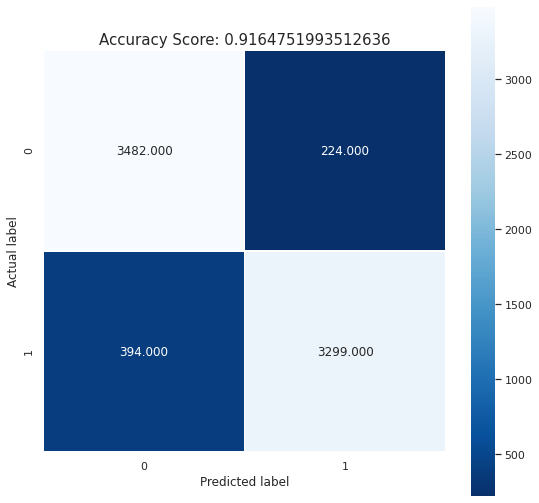

In [61]:
cm1 = metrics.confusion_matrix(y_test, predictions_rf)
plt.figure(figsize=(9,9))
sns.heatmap(cm1, annot=True, fmt=".3f", linewidths=.5, 
            square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(rf_acc)
plt.title(all_sample_title, size = 15);

## ROC Curve

Text(0.5, 1.0, 'ROC Curve, AUC = 0.972')

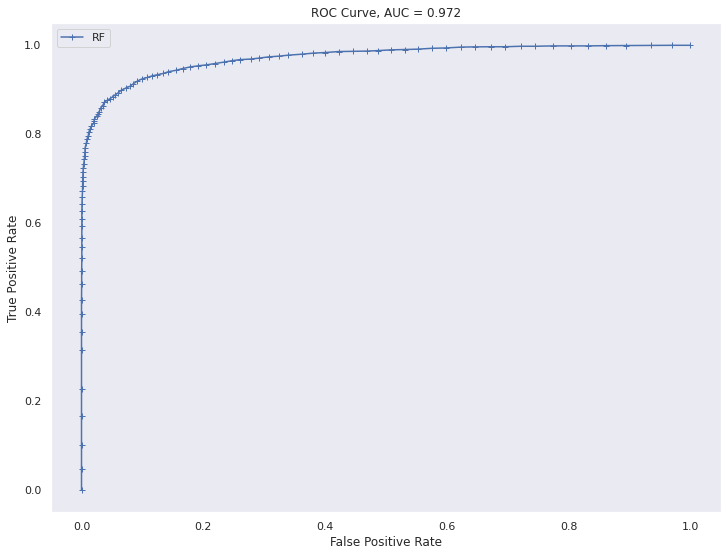

In [62]:
plt.figure(figsize=(12,9))
plt.plot(rf_fpr, rf_tpr, marker='+', label='RF')
plt.grid()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.title(f'ROC Curve, AUC = {rf_auc:.3f}')

## Precision - Recall Curve

Text(0.5, 1.0, 'Precision-Recall curve')

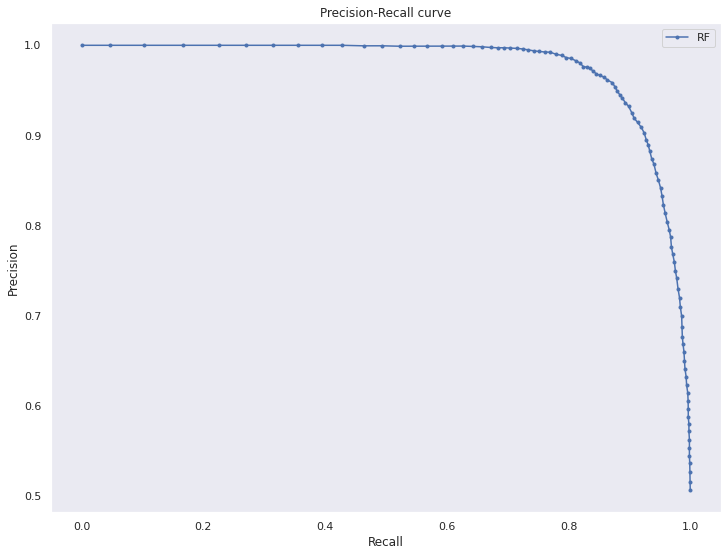

In [63]:
plt.figure(figsize=(12,9))
plt.plot(recall1, precision1, marker='.', label='RF')
plt.grid()
plt.legend()
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title(f'Precision-Recall curve')

## Cross Evaluation of this model

Model Evaluation - Random Forest
 Random Forest - Accuracy result 0.9101229891827967 +/- 0.0008875981057191773
 Random Forest - ROC_AUC result 0.9695686399810294 +/- 0.0010885038956986366
 Random Forest - Precision result 0.9291228453191248 +/- 0.004868110283756643
 Random Forest - Recall result 0.8870316974545943 +/- 0.004216809881787984


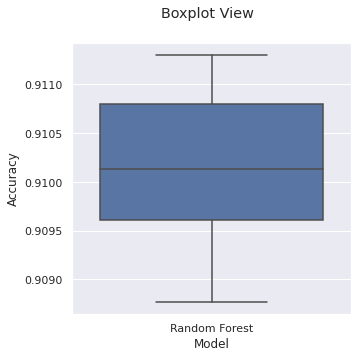

In [64]:
x = scaler.fit_transform(x)
# prepare models
models = []
models.append(('Random Forest', rfmodel))
print('Model Evaluation - Random Forest')
# evaluate each model in turn
results = []
names = []

for name, model in models:
	kfold = model_selection.KFold(n_splits=5,random_state=7,shuffle=True)
	cv_results = model_selection.cross_val_score(model,x,y,cv=kfold,scoring='accuracy')
	cv_results2 = model_selection.cross_val_score(model,x,y,cv=kfold,scoring='roc_auc')
	cv_results3 = model_selection.cross_val_score(model,x,y,cv=kfold,scoring='precision')
	cv_results4 = model_selection.cross_val_score(model,x,y,cv=kfold,scoring='recall')
	results.append(cv_results)
	names.append(name)
	print(f' {name} - Accuracy result {cv_results.mean()} +/- {cv_results.std()}')
	print(f' {name} - ROC_AUC result {cv_results2.mean()} +/- {cv_results2.std()}')
	print(f' {name} - Precision result {cv_results3.mean()} +/- {cv_results3.std()}')
	print(f' {name} - Recall result {cv_results4.mean()} +/- {cv_results4.std()}')

fig = plt.figure(figsize=(5,5))
fig.suptitle('Boxplot View')
ax = fig.add_subplot(111)
sns.boxplot(data=results)
ax.set_xticklabels(names)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.show()

## RF model with important features
### Selecting important features -

In [65]:
feature_imp = pd.DataFrame(rfmodel.feature_importances_,index=feature_cols,columns=['importance']).sort_values('importance',ascending=False)
feature_imp

,importance
motor,0.101411
O2,0.088586
GCSTotal,0.074857
verbal,0.074119
eyes,0.074085
los,0.052158
MAP,0.050878
heartrate,0.048301
SBP,0.046403
respiratoryrate,0.044501


## Visualizing important features

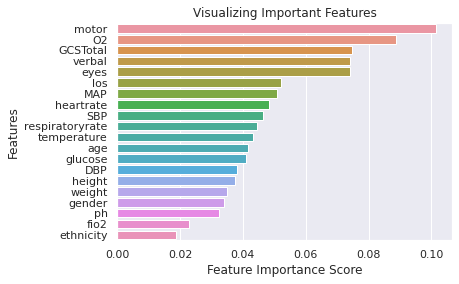

In [66]:
sns.barplot(x=feature_imp.importance,y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Visualizing Important Features')
plt.show()

## Finding what features were important - 

In [67]:
from sklearn.feature_selection import SelectFromModel
feature = SelectFromModel(rfmodel)
fit = feature.fit_transform(x_train,y_train)
print(f'Number of features selected are :  {fit.shape[1]}')

Number of features selected are :  7


In [68]:
for feature_list_index in feature.get_support(indices=True):
    print(f'Features selected are : {feature_imp.index[feature_list_index]}')

Features selected are : verbal
Features selected are : eyes
Features selected are : los
Features selected are : MAP
Features selected are : age
Features selected are : height
Features selected are : ph


In [0]:
x_imp_train = feature.transform(x_train)
x_imp_test = feature.transform(x_test)

## RF model for important features

In [70]:
rf_imp = RandomForestClassifier(n_estimators=100,class_weight='balanced')
rf_imp.fit(x_imp_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
pred_imp = rf_imp.predict(x_imp_test)
rfimp_proba = rf_imp.predict_proba(x_imp_test)

In [0]:
rfimp_proba=rfimp_proba[:,1]

## Classification report

In [73]:
acc_imp = rf_imp.score(x_imp_test,y_test)
print(classification_report(y_test,pred_imp))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86      3706
           1       0.88      0.82      0.85      3693

    accuracy                           0.85      7399
   macro avg       0.85      0.85      0.85      7399
weighted avg       0.85      0.85      0.85      7399



In [0]:
p = metrics.precision_score(y_test, pred_imp)
r = metrics.recall_score(y_test, pred_imp)
f1 = metrics.f1_score(y_test, pred_imp)

In [0]:
rf1_fpr, rf1_tpr, thresholds = metrics.roc_curve(y_test,rfimp_proba)
rf1auc= metrics.roc_auc_score(y_test,rfimp_proba)

In [76]:
print('*'*30)
print(f'Random Forest after Feature selection: \n')
print(f'\t Acc = {acc_imp:.3f} \n\t Precision={p:.3f} \n\t Recall={r:.3f} \n\t F1={f1:.3f} \n\t AUC={rf1auc:.3f} \n\t')

******************************
Random Forest after Feature selection: 

	 Acc = 0.853 
	 Precision=0.876 
	 Recall=0.823 
	 F1=0.849 
	 AUC=0.929 
	


In [0]:
precision2, recall2, _ = metrics.precision_recall_curve(y_test, rfimp_proba)

## Confusion Matrix

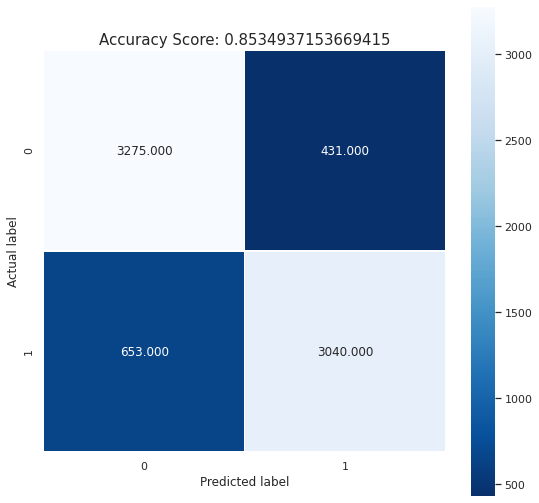

In [78]:
cm2 = metrics.confusion_matrix(y_test, pred_imp)
plt.figure(figsize=(9,9))
sns.heatmap(cm2, annot=True, fmt=".3f", linewidths=.5, 
            square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_imp)
plt.title(all_sample_title, size = 15);

## ROC Curve

Text(0.5, 1.0, 'ROC Curve, AUC = 0.929')

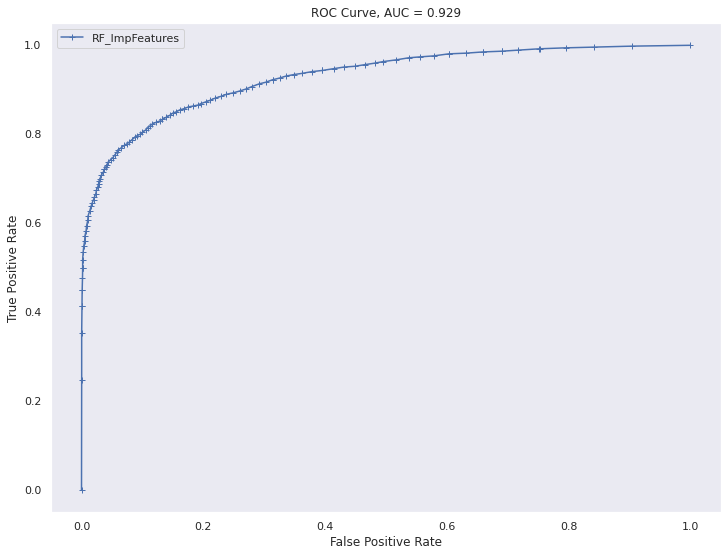

In [79]:
plt.figure(figsize=(12,9))
plt.plot(rf1_fpr, rf1_tpr, marker='+', label='RF_ImpFeatures')
plt.grid()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.title(f'ROC Curve, AUC = {rf1auc:.3f}')

## Precision - Recall curve

Text(0.5, 1.0, 'Precision-Recall curve')

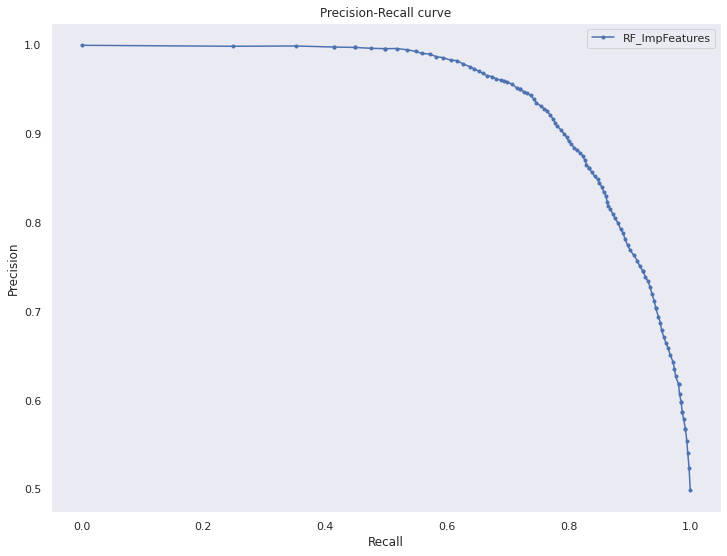

In [80]:
plt.figure(figsize=(12,9))
plt.plot(recall2, precision2, marker='.', label='RF_ImpFeatures')
plt.grid()
plt.legend()
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title(f'Precision-Recall curve')

## Cross evaluation of this model

Model Evaluation - Random forest with Imp. Features
 RF with Important features - Accuracy result 0.8469726898718282 +/- 0.003609201448922179
 RF with Important features - ROC_AUC result 0.924589858599224 +/- 0.001913235314474467
 RF with Important features - Precision result 0.8733429408359059 +/- 0.01156458984750042
 RF with Important features - Recall result 0.8128199583849783 +/- 0.001614835689838694


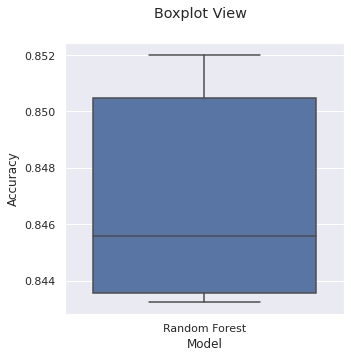

In [81]:
x = scaler.fit_transform(x)
x = feature.transform(x)
# prepare models
models1 = []
models1.append(('RF with Important features', rf_imp))
print('Model Evaluation - Random forest with Imp. Features')
# evaluate each model in turn
results1 = []
names1 = []

for name, model in models1:
	kfold = model_selection.KFold(n_splits=5,random_state=7,shuffle=True)
	cv_results = model_selection.cross_val_score(model,x,y,cv=kfold,scoring='accuracy')
	cv_results2 = model_selection.cross_val_score(model,x,y,cv=kfold,scoring='roc_auc')
	cv_results3 = model_selection.cross_val_score(model,x,y,cv=kfold,scoring='precision')
	cv_results4 = model_selection.cross_val_score(model,x,y,cv=kfold,scoring='recall')
	results1.append(cv_results)
	names1.append(name)
	print(f' {name} - Accuracy result {cv_results.mean()} +/- {cv_results.std()}')
	print(f' {name} - ROC_AUC result {cv_results2.mean()} +/- {cv_results2.std()}')
	print(f' {name} - Precision result {cv_results3.mean()} +/- {cv_results3.std()}')
	print(f' {name} - Recall result {cv_results4.mean()} +/- {cv_results4.std()}')

fig = plt.figure(figsize=(5,5))
fig.suptitle('Boxplot View')
ax = fig.add_subplot(111)
sns.boxplot(data=results1)
ax.set_xticklabels(names)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.show()

## Visual comparison of classifiers

## Confusion Matrix comparison

Text(902.8781818181819, 0.5, 'Actual label')

<Figure size 2000x2000 with 0 Axes>

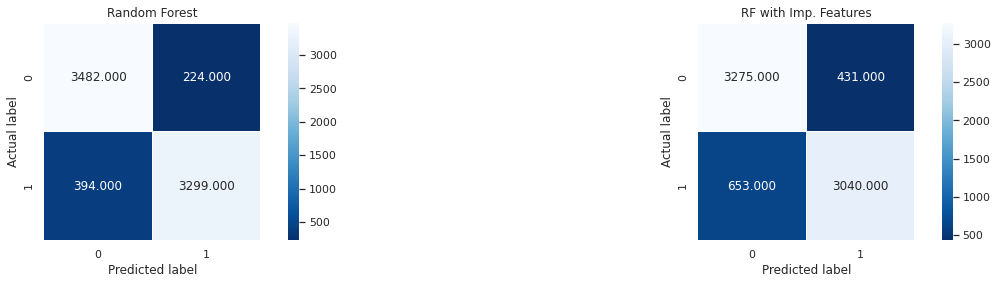

In [82]:
plt.figure(figsize=(20,20),dpi=100)
fig, (ax,ax2) = plt.subplots(ncols=2)
fig.subplots_adjust(right=2.9)
sns.heatmap(cm1, annot=True, fmt=".3f", linewidths=.5, 
            square = True, cmap = 'Blues_r',ax=ax);
ax.set_title('Random Forest')
ax.set_xlabel('Predicted label')
ax.set_ylabel('Actual label')
sns.heatmap(cm2, annot=True, fmt=".3f", linewidths=.5, 
            square = True, cmap = 'Blues_r',ax=ax2);
ax2.set_title('RF with Imp. Features')
ax2.set_xlabel('Predicted label')
ax2.set_ylabel('Actual label')

## ROC Curve comparison

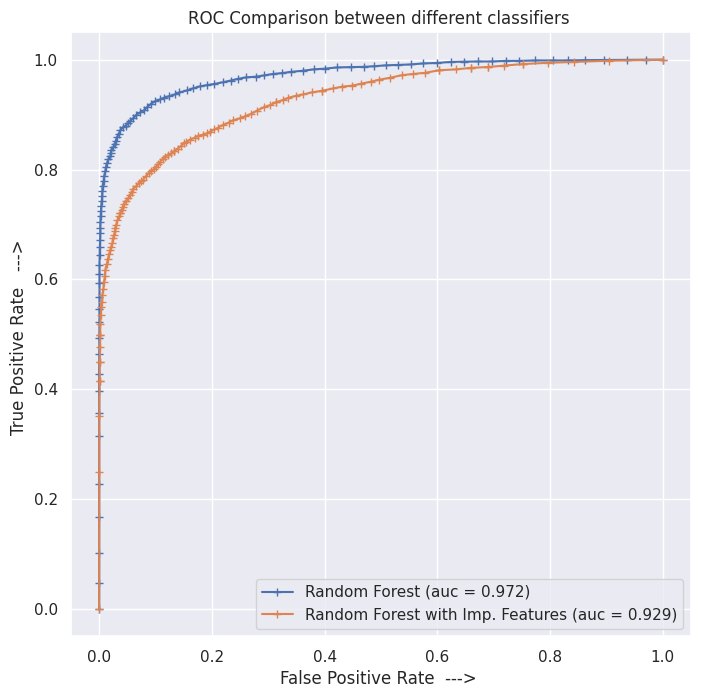

In [83]:
plt.figure(figsize=(8,8),dpi=100)
plt.plot(rf_fpr, rf_tpr, marker='+', label='Random Forest (auc = %0.3f)' % rf_auc)
plt.plot(rf1_fpr, rf1_tpr, marker='+', label='Random Forest with Imp. Features (auc = %0.3f)' % rf1auc)

plt.xlabel('False Positive Rate  ---> ')
plt.ylabel('True Positive Rate   ---> ')
plt.legend()
plt.title('ROC Comparison between different classifiers ')
plt.show()

## Precision - Recall curve comparison

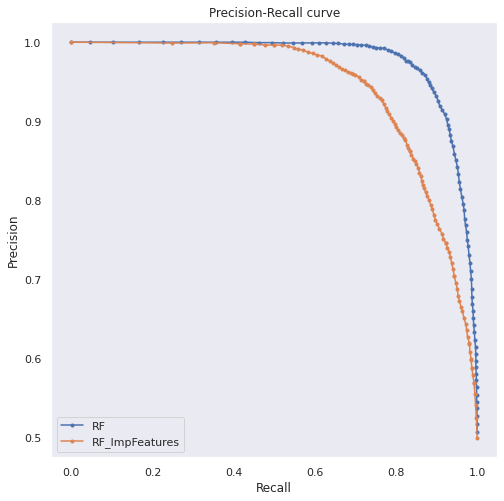

In [84]:
plt.figure(figsize=(8,8))
plt.plot(recall1, precision1, marker='.', label='RF')
plt.plot(recall2, precision2, marker='.', label='RF_ImpFeatures')

plt.grid()
plt.legend()
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title(f'Precision-Recall curve')
plt.show()